In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.optimize
import json

## Segédfüggvények

In [2]:
# determines if n is probably-prime or composite using miller rabin test. Tests k times
def is_prime(n, k=20): # miller-rabin test
    if n == 2:
        return True
    for _ in range(k):
        witness = 1
        a = random.randint(2, n-1)
        if gcd(a, n)[1] != 1:
            return False
        d = n-1
        r = 0
        while d % 2 == 0:
            d = d//2
            r += 1
        s = int_pow_mod(a, d, n)
        if s == 1:
            witness = 0
        for i in range(r):
            if s == n-1:
                witness = 0
            s = s**2 % n
        if witness == 1:
            return False
    return True

def gcd(m, n): # euclid's algorithm
    a = max(m,n)
    b = min(m,n)
    if a%b == 0:
        return a, b
    c = a % b
    return gcd(b, c) # c a legnagyobb közös osztó

In [3]:
def int_nth_root(A, n): # calculate floor of nth root of A
    if A<0:
        if n%2 == 0:
            raise ValueError
        return -int_nth_root(-A,n)
    if A==0:
        return 0
    n1 = n-1
    if A.bit_length() < 1024: # float(n) safe from overflow
        xk = int( round( pow(A,1.0/n) ) )
        xk = ( n1*xk + A//pow(xk,n1) )//n # Ensure xk >= floor(nthroot(A)).
    else:
        xk = 1 << -(-A.bit_length()//n) # 1 << sum(divmod(A.bit_length(),n))
                                        # power of 2 closer but greater than the nth root of A
    while True:
        d = A // pow(xk,n1)
        if xk <= d:
            return xk
        xk = (n1*xk + d)//n

In [4]:
def two_pow(A, k): # computes A**(2**k), A: L bit int
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 
    return result  # if k < L: max O(L^3) operations

def int_pow(A, n): # computes A**n in polynomal time, A: L bit int
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow(A, i)
    return result # if n < A: max O(L^4) operations


In [5]:
def two_pow_mod(A, k, N): #computes A**(2**k) mod N, A: L bit int
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 % N
    return result  # if  k < L: max O(L^3)

def int_pow_mod(A, n, N): #computes A**n mod N in polynomal time, A: L bit integer
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow_mod(A, i, N) % N
    return result # if n < A:max O(L^4) operations

In [6]:
def find_int_pow(N):
    n = N.bit_length()
    for i in range(2, n):
        a = int_nth_root(N, i)
        if int_pow(a, i) == N:
            return a, i
    return N, 1

def order(a, N): 
    if gcd(a, N)[1] != 1:
        raise ValueError("a and N have to be coprime")
    s = 1
    i = 0
    while i == 0 or s != 1:
        s = (a*s) % N
        i += 1
    return i

## Kapuk száma, mélység

In [7]:
def dep(n):
    return 232*n**3+282*n**2+32*n

def cx(n):
    return 16*n**4+152*n**3+188*n**2+104*n

def sing(n):
    return 24*n**4 + 176*n**3 + 230*n**2 + 139*n

In [8]:
file1 = open("complexity.txt", "r")
compl = json.load(file1)
file1.close()

In [9]:
file2 = open("complexity2.txt", "r")
compl2 = json.load(file2)
file2.close()

Text(0, 0.5, 'egy qubites kapuk száma')

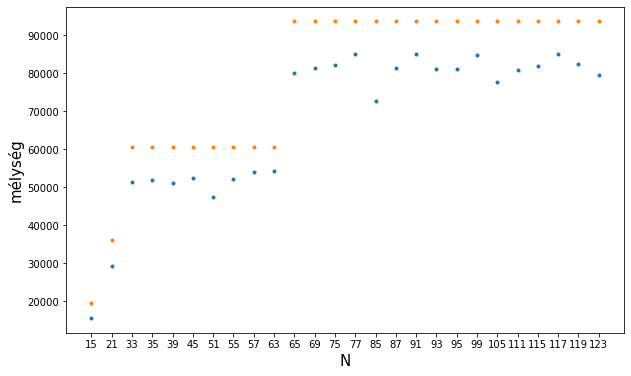

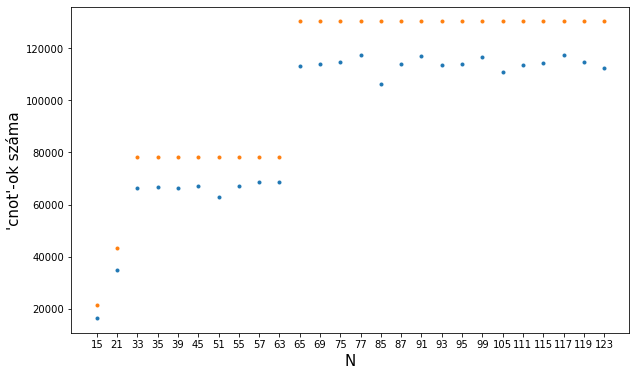

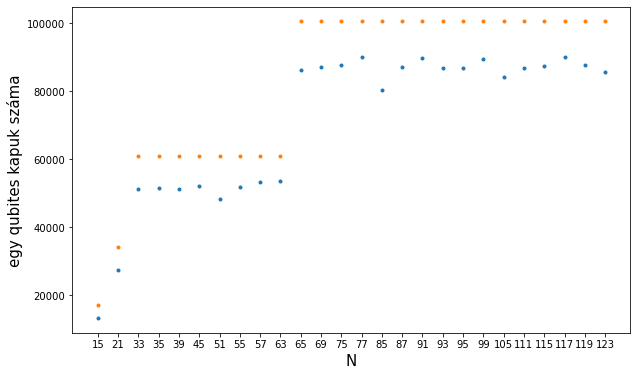

In [155]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(depth.keys(), [max(depth[N]) for N in depth.keys()], '.')
ax.plot(depth.keys(), [dep(int(N).bit_length()) for N in depth.keys()], '.')
ax.set_xlabel('N', fontsize=15)
ax.set_ylabel('mélység', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(single.keys(), [max(single[N]) for N in single.keys()], '.')
ax.plot(single.keys(), [sing(int(N).bit_length()) for N in single.keys()], '.')
ax.set_ylabel("'cnot'-ok száma", fontsize=15)
ax.set_xlabel('N', fontsize=15)
#ax.set_xscale('log')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cnot.keys(), [max(cnot[N]) for N in cnot.keys()], '.')
ax.plot(cnot.keys(), [cx(int(N).bit_length()) for N in cnot.keys()], '.')
ax.set_xlabel('N', fontsize=15)
ax.set_ylabel('egy qubites kapuk száma', fontsize=15)

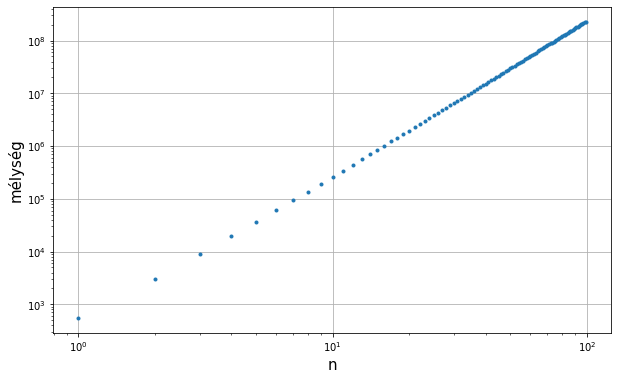

In [159]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(100), [dep(n) for n in range(100)], '.')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('n', fontsize=15)
ax.set_ylabel('mélység', fontsize=15)
ax.grid()

## futtatások száma

In [10]:
def lin(x, a, b):
    return a*x+b

def log(x, a):
    return(a*np.log2(x))

In [106]:
num = []
E = []
Expect = {}
for N in range(4, 1000):
    if is_prime(N)==False and find_int_pow(N)[1] == 1 and N%2 == 1:
        num.append(N)
        
        i = 0 # itt számláljuk, hogy hány sikeres 'a' van 
        frac = []
        for a in range(2, N-1):
            if gcd(a, N)[1] == 1:
                r = order(a, N)
                j = 0
                for s in range(1, r):
                    if gcd(s, r)[1] == 1:
                        j += 1
                frac.append(r/j)
                if r%2 == 0 and int_pow_mod(a, r//2, N) != N-1:
                    i += 1
            else:
                i += 1
                
        q = i/(N-3)
        E.append(1/(q*(N-3))*sum(frac))
        Expect[N] = 1/(q*(N-3))*sum(frac)

[0.28252494]


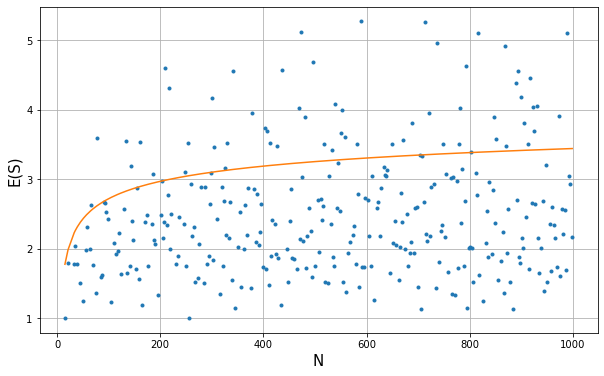

In [137]:
num = np.array(num, dtype = int)
fit, cov = scipy.optimize.curve_fit(log, num, E, p0=[1])
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(num, E, '.')
ax.set_xlabel('N', fontsize=15)
ax.set_ylabel('E(S)', fontsize=15)
ax.grid()
ax.plot(num, np.log(np.log(num))*np.exp(np.euler_gamma))
print(fit)

### futtatások száma hibákkal

In [11]:
def expect(n, p=0): # estimate of expected value of number of runs
    P = (1-p)**(2*n+2)
    return (np.log(np.log(2))+np.log(n))*np.exp(np.euler_gamma)/P

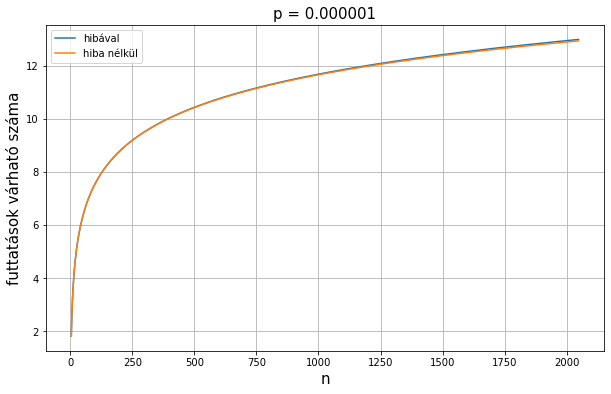

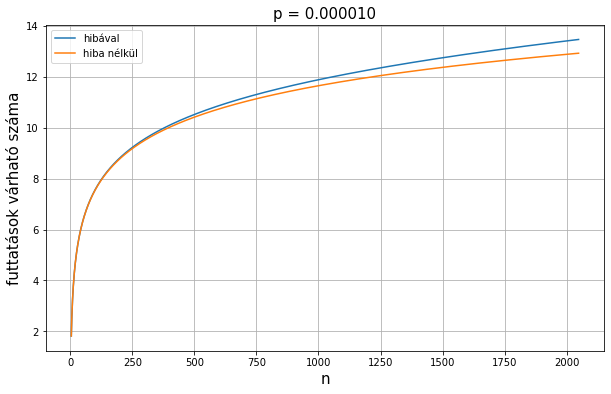

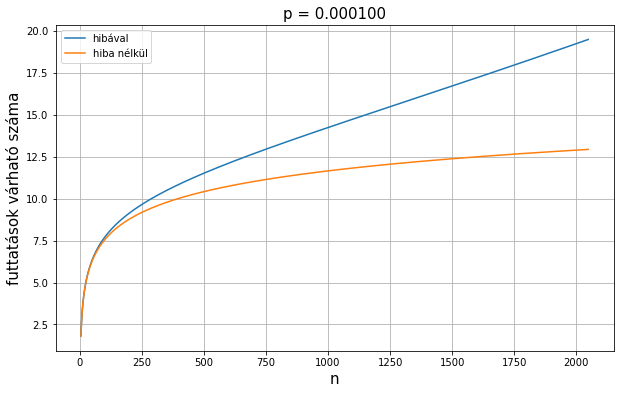

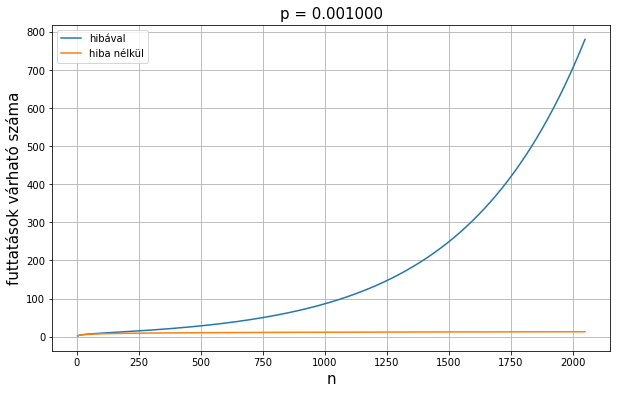

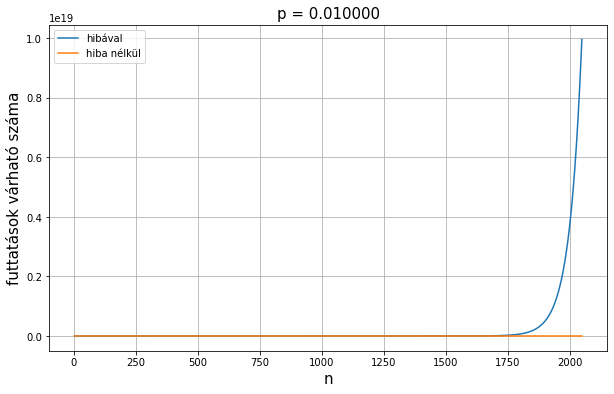

In [148]:
for p in np.logspace(-6, -2, num = 5):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid()
    ax.set_title("p = %f" % p, fontsize=15)
    ax.set_xlabel("n", fontsize=15)
    ax.set_ylabel('futtatások várható száma', fontsize=15)
    n = np.arange(4, 2049)
    ax.plot(n, expect(n, p), '-', label='hibával')
    ax.plot(n, expect(n), '-', label='hiba nélkül')
    ax.legend()

## Várható időtartam

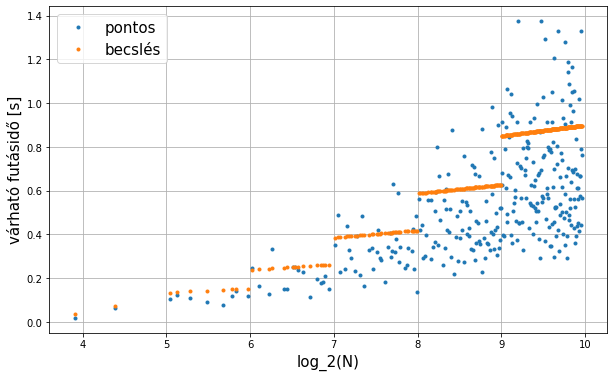

In [149]:
E = np.array(E)
power = 3
n = np.array([int(N).bit_length() for N in num])
x = num

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.log2(num), 10**-6*E*dep(n), '.', label='pontos')
ax.plot(np.log2(x), 10**-6*np.log(np.log(x))*np.exp(np.euler_gamma)*np.array([dep(int(N).bit_length()) for N in x]), '.', label='becslés')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('log_2(N)', fontsize=15)
ax.set_ylabel('várható futásidő [s]', fontsize=15)

ax.grid()
ax.legend(loc='best', fontsize=15)

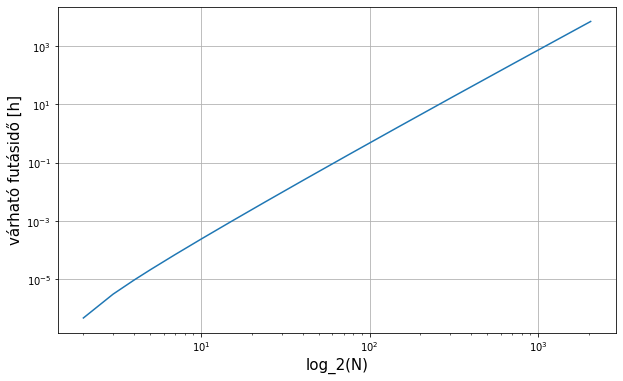

In [69]:
power = 11
n = np.arange(2, 2049)
n = n.astype('float64')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n, 10**-6*expect(n)*dep(n)/3600, '-', label='becslés')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('log_2(N)', fontsize=15)
ax.set_ylabel('várható futásidő [h]', fontsize=15)
ax.grid()

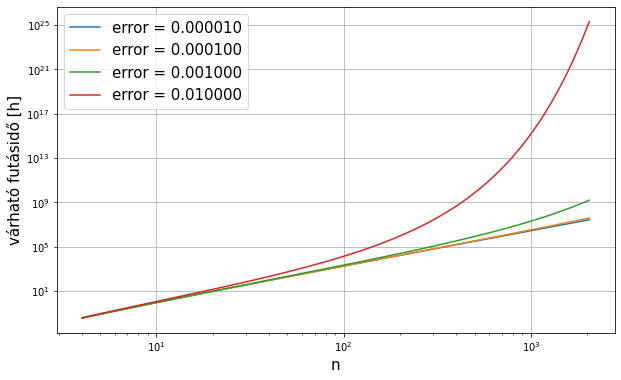

In [23]:
n = np.arange(4, 2049, dtype='float64')
fig, ax = plt.subplots(figsize=(10, 6))
for p in np.logspace(-5, -2, num = 4):
    ax.plot(n, 10**-6*dep(n)*expect(n, p), '-', label='error = %f' %p) 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("n", fontsize=15)
ax.set_ylabel('várható futásidő [h]', fontsize=15)
ax.legend(fontsize=15)
ax.grid()

## 2048 bites szám faktorizásásához szükséges idő

Text(0.5, 0, '1-p')

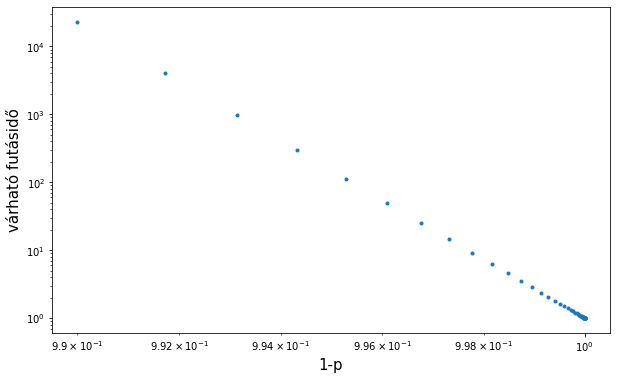

In [173]:
n = 1000
p = np.logspace(-6, -2, num = 50, dtype='float64')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(1-p, 1/(1-p)**n, '.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('várható futásidő', fontsize = 15)
ax.set_xlabel('1-p', fontsize = 15)